# Right-hand rule for deadlock resolution: n-agent situation

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env


import shapely

from panav.ORCA import VO, ORCA_Agent
from panav.SAMP import SA_MILP_Planning
from panav.util import unique_tx

%load_ext autoreload
%autoreload 2

In [2]:
top, bottom = 6,-6
start_x_offset = 5 
goal_x_offset = 7
N = 5

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])

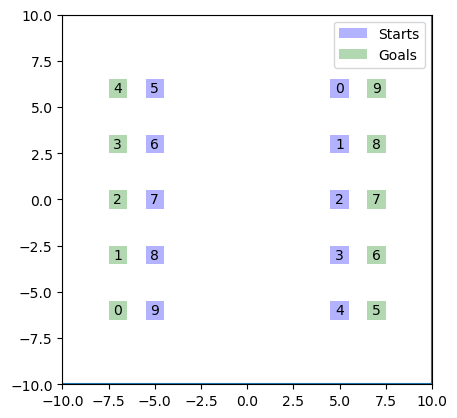

In [9]:
start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

# O1 = Box2DRegion((-2.5,2.5),(1.1,10))
# O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))
# obstacles = [O1,O2]

obstacles = []

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,obstacles,starts,goals)

draw_env(env)

**Compute individual paths that avoid all static obstacles**

In [10]:
agents = set(np.arange(len(start_locs)))

plans = []

bloating_r = 0.5
d = 2
K = 10
t0 = 0
vmax = 1.0

for agent in agents:
    start = env.starts[agent]
    goal = env.goals[agent]

    times, xs = SA_MILP_Planning(env,start,goal,vmax,bloating_r,\
                                 [],\
                                d,K,t0)

    times,xs = unique_tx(times,xs)
    plans.append(xs)

In [11]:


tau = 2 # The safe time interval. Can be generously long.
exec_tau = 0.5 * tau 

detection_radius = bloating_r * 10

# The execution time of ORCA velocity.
# Can be shorter than the safe interval tau.

pos = []
vs = [np.zeros(start_locs[0].shape) for a in agents]
v_prefs = [np.zeros(start_locs[0].shape) for a in agents]

protocol = 0

orcas = [ORCA_Agent(protocol,tau,bloating_r,vmax,np.array(p),v) 
         for p,v in zip(start_locs,vs)]

curr_wp_index = [0 for a in agents]

makespans = np.zeros(len(agents))

curr_time = 0
for _ in range(400):
    pos.append(np.array([a.p for a in orcas]))
    
    # Compute the preferred velocity.
    for agent in agents:
        wp = plans[agent][:,curr_wp_index[agent]]
        to_wp = wp-orcas[agent].p
        
        # See if the agent has reached the current waypoint.
        if np.linalg.norm(to_wp)<= bloating_r:  
            curr_wp_index[agent] = \
            np.min([curr_wp_index[agent]+1,   
                    plans[agent].shape[1]-1
                                  ])

        
        v_prefs[agent] = vmax * to_wp / np.linalg.norm(to_wp)
    
    # Update v_opt
    for a in agents:
        orcas[a].update_v_opt(v_prefs[a])
    
    # Compute the safe velocity.
    for a in agents:    
        
        neighbors = [b for b in agents-{a}
            if np.linalg.norm(orcas[a].p-orcas[b].p)<= detection_radius]
        
        orcas[a].update_v(v_prefs[a],env.obstacles,
                        [orcas[b] for b in neighbors])
    
    # Execute the safe velocity.
    all_reached = True
    curr_time +=exec_tau
    for a in agents:
        if np.linalg.norm(orcas[a].p \
                        - goals[a].project(orcas[a].p))\
                        >=1*bloating_r:
            orcas[a].p += orcas[a].v*exec_tau
            all_reached = False
            makespans[a] = curr_time
    
    
    if all_reached:
        break

Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential deadlock
Potential de

In [12]:
print([o.v for o in orcas])

[array([-0.50565, -0.86274]), array([-0.42422, -0.35036]), array([0.99967, 0.02563]), array([-0.77109,  0.49506]), array([-0.80503,  0.59323]), array([-0.92061,  0.12036]), array([ 0.57281, -0.23194]), array([-0.9416 , -0.29634]), array([0.66941, 0.60192]), array([-0.42136, -0.63434])]


**Visualize the trajectories**

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


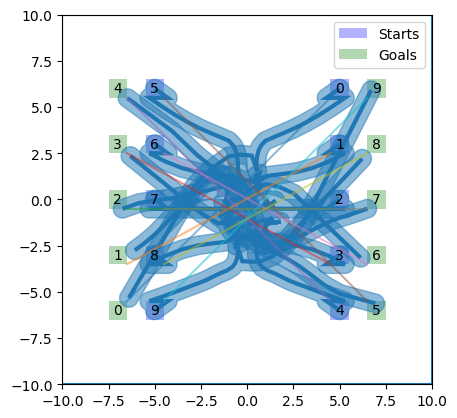

In [13]:

from shapely.plotting import plot_polygon, plot_line
pos = np.array(pos)

ax = plt.gca()
draw_env(env,plans,ax)

for a in agents:
    line = shapely.geometry.LineString(pos[:,a,:])
    dilated = line.buffer(bloating_r)

    plot_line(line, ax=ax, add_points=False, linewidth=3)
    plot_polygon(dilated, ax=ax, add_points=False, alpha=0.5)

**Animate the motions**

In [15]:
from panav.viz import animation
from IPython.display import HTML, display

dt = 0.05

pos_to_ani = [pos[:,a,:].T for a in agents]
anim = animation(env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
anim.save('n_body_right_hand_rule.gif')
plt.close() 

MovieWriter ffmpeg unavailable; using Pillow instead.
